# API Comparison for Anomaly Detection in Time Series
현재 클라우드 시장에서 anomaly detection를 지원하는 API들은 대부분 time series에 대한 것들이다. 여기에 기존의 오픈소스들 중 time series 에 대한 anomaly detection를 지원하는 라이브러리를 더해 총 3가지의 환경에서 f1 score를 기준으로 성능비교를 진행할 것이다.

* Luminol python library
* Amazon Web Service SageMaker
* Microsoft Azure

In [2]:
#existing library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json, datetime

In [3]:
#custom library
import sampling
from AWS import aws
from noAPI.Luminol import luminol_
from Azure import azure

## Dataset
기술된 API들은 input 형식에 있어 여러가지 제약을 두고 있다.

## 확장자
Luminol
* string
* dict
* lumnol.modules.time_series.TimeSeries

AWS
* CSV

Azure
* JSON

## 시계열 인덱스 형식
* Luminol: datetime.timestamp
* AWS: datetime.datetime
* Azure: datetime.datetime



## 내용적인 제약

Azure (https://docs.microsoft.com/en-us/azure/cognitive-services/anomaly-detector/quickstarts/detect-data-anomalies-python)
* data points separated by the same interval, with no more than 10% of the expected number of points missing.
* at least 12 data points if your data doesn't have a clear seasonal pattern.
* at least 4 pattern occurrences if your data does have a clear seasonal pattern.
* time interval (granularity) must have to be in 'daily', 'minutely', 'hourly', 'weekly', 'monthly' or 'yearly'

따라서 우리가 사용할 수 있는 데이터셋의 조건은 다음과 같다.

* 시간의 간격이 분, 시간, 일, 주 혹은 달 간격으로 일정한 시계열 데이터
* anomal point에 대한 labeling이 되어 있는 시계열 데이터

# Dataset - Exchange-4 CPM

In [21]:
cpm_df = pd.read_csv('https://raw.githubusercontent.com/numenta/NAB/master/data/realAdExchange/exchange-4_cpm_results.csv')

dt_cpm = cpm_df['timestamp'].values
ts_cpm = []
for i in dt_cpm:
    datetimes = datetime.datetime.strptime(i,"%Y-%m-%d %H:%M:%S")
    i = datetimes.date().isoformat()
    ts_cpm.append(datetime.datetime.timestamp(datetimes))
    
y_cpm = np.array(cpm_df['value']).astype('float')

abn_pt_cpm = np.array([
    "2011-07-16 09:15:01",
    "2011-08-01 07:15:01",
    "2011-08-23 08:15:01",
    "2011-08-28 13:15:01"
])
abn_pt_cpm = cpm_df.loc[cpm_df['timestamp'].isin(abn_pt_cpm)].index.values

## Visualization for Dataset

Text(0.5, 1.0, 'Exchange-4 CPM')

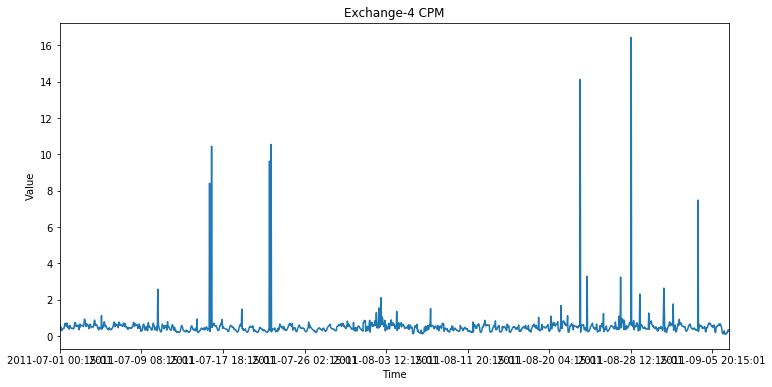

In [23]:
#visualize virtual dataset
req_stamp_cpm = pd.Series(y_cpm, index = dt_cpm)
req_stamp_cpm.plot(x=req_stamp_cpm.index, y=req_stamp_cpm.values, figsize=(12,6))
plt.xlabel('Time')
plt.ylabel('Value')
plt.title("Exchange-4 CPM")

아래 그래프는 anomal point와 함께 나타낸 것이다.

Text(0.5, 1.0, 'Exchange-4 CPM')

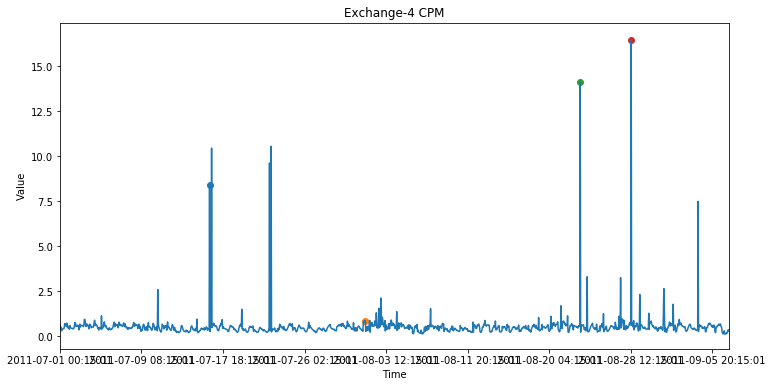

In [24]:
#visualize virtual dataset
req_stamp_cpm.plot(x=req_stamp_cpm.index, y=req_stamp_cpm.values, figsize=(12,6))
for i in abn_pt_cpm:
    plt.scatter(x=i, y=y_cpm[i])
plt.xlabel('Time')
plt.ylabel('Value')
plt.title("Exchange-4 CPM")

# Dataset - Virtual Dataset
위의 조건을 만족하는 가상의 데이터셋을 만들어 성능을 비교해볼 것이다. Sine 곡선에 White 노이즈를 첨가된 데이터에 랜덤으로 anomaility를 더해줄 것이다. 그렇게 만들어진 값들에 time index를 붙여주면 가상의 시계열 데이터셋이 완성된다.

In [11]:
#generate virtual dataset
'''
sig = degree of anomalities
y = list of generated values
abn_pt = list of indices of abnormal points
'''
abn_pt, y = sampling.value_modeling(sig = 5, cycle = 300, abn_num = 15)

# datetime index: for aws and azure
dt = sampling.gen_time_idx(dtype = 'datetime')

# timestamp index: for luminol
ts = sampling.gen_time_idx(dtype = 'timestamp')

## Visualization for Dataset

In [18]:
#visualize virtual dataset
# req_stamp = pd.Series(y, index = dt)
# req_stamp.plot(x=req_stamp.index, y=req_stamp.values, figsize=(12,6))
# plt.xlabel('Time')
# plt.ylabel('Value')
# plt.title("Virtual Time Series")

아래 그래프는 anomal point와 함께 나타낸 것이다.

In [19]:
#visualize virtual dataset
# req_stamp.plot(x=req_stamp.index, y=req_stamp.values, figsize=(12,6))
# for i in abn_pt:
#     plt.scatter(x=i, y=y[i])
# plt.xlabel('Time')
# plt.ylabel('Value')
# plt.title("Virtual Time Series")

# Result
각 API 별 f1 score와 True Positive, False Positive(이상이라고 잘못 진단한 경우), False Negative(이상이라고 진단하지 못한 경우)를 시각화한 결과는 다음과 같다.

## Luminol

## Results for Virtual Dataset

In [14]:
lm = luminol_.luminol()
lm.set_data(abn_pt, y, ts)

luminol_f1 = lm.f1_metrics()
print("F1 score for luminol is: %f" %luminol_f1)

# lm.vis()

F1 score for luminol is: 0.560000


## Results for Exchange-4 CPM

F1 score for luminol is: 0.000000


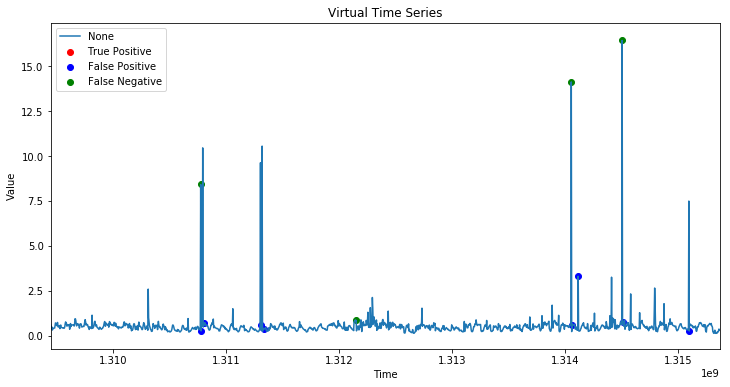

In [26]:
lm_cpm = luminol_.luminol()
lm_cpm.set_data(abn_pt_cpm, y_cpm, ts_cpm)

luminol_f1_cpm = lm_cpm.f1_metrics()
print("F1 score for luminol is: %f" %luminol_f1_cpm)

lm_cpm.vis()

# Azure

## Results for Virtual Dataset

In [12]:
az = azure.azure()
az.set_data(abn_pt, y, dt, 
            url = "[url]", 
            endpoint = "[endpoint]", 
            key = "[key]")

azure_f1 = az.f1_metrics()
print("F1 score for luminol is: %f" %azure_f1)

# az.vis()

F1 score for luminol is: 0.125000


## Results for Exchange-4 CPM

F1 score for luminol is: 0.157895


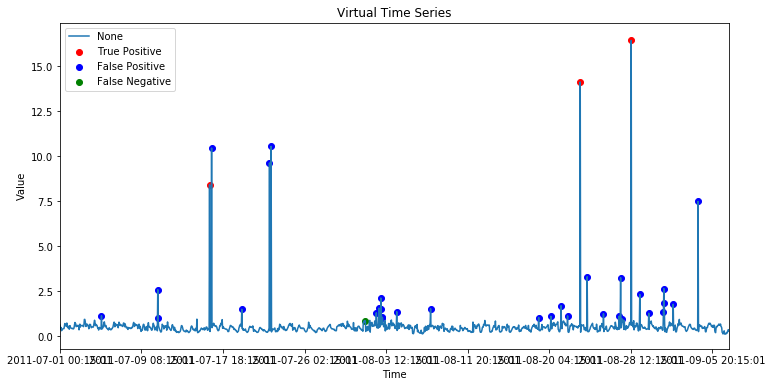

In [13]:
az_cpm = azure.azure()
az.set_data(abn_pt, y, dt, 
            url = "[url]", 
            endpoint = "[endpoint]", 
            key = "[key]")

azure_f1_cpm = az_cpm.f1_metrics()
print("F1 score for luminol is: %f" %azure_f1_cpm)

az_cpm.vis()

# AWS

## Results for Virtual Dataset

//////boto3 session generating

//////check if the bucket exists
Training input/output will be stored in: s3://doyeongkim-anomaly-detection/sagemaker/rcf-benchmarks

//////define sagemaker session

//////define rcf model

//////fitting rcf model


/root/anomaly_detection/AWS/aws.py:72: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  rcf.fit(rcf.record_set(self.df.value.as_matrix().reshape(-1,1)))


2019-05-23 14:41:24 Starting - Starting the training job...
2019-05-23 14:41:27 Starting - Launching requested ML instances......
2019-05-23 14:42:31 Starting - Preparing the instances for training...
2019-05-23 14:43:26 Downloading - Downloading input data......
2019-05-23 14:44:30 Training - Training image download completed. Training in progress.
2019-05-23 14:44:30 Uploading - Uploading generated training model
Docker entrypoint called with argument(s): train
[05/23/2019 14:44:27 INFO 139885588522816] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'_ftp_port': 8999, u'num_samples_per_tree': 256, u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'_log_level': u'info', u'_kvstore': u'dist_async', u'force_dense': u'true', u'epochs': 1, u'num_trees': 100, u'eval_metrics': [u'accuracy', u'precision_recall_fscore'], u'_num_kv_servers': u'auto', u'mini_batch_size': 1000}
[05/23/2019 14:44:27 INFO 139885588522816]

/root/anomaly_detection/AWS/aws.py:86: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  df_numpy = self.df.value.as_matrix().reshape(-1,1)


F1 score for aws is: 0.222222


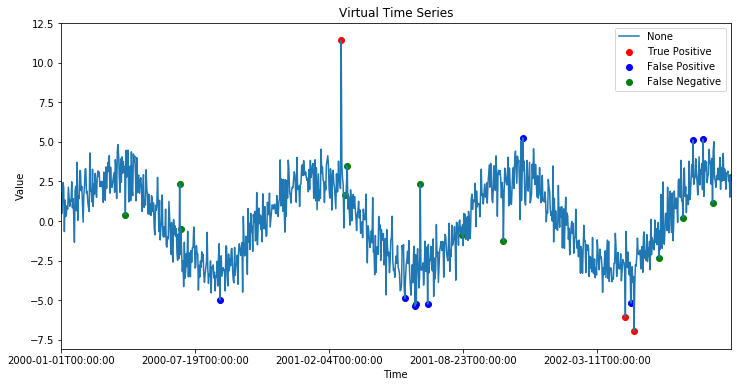

In [4]:
aw = aws.aws()
aw.set_data(abn_pt, y, dt)

aw.inference(
            bucket = '[bucket_name]',
            prefix = '[prefix_to_bucket]',
            execution_role = '[your_execution_role]',
            instance_type = '[instance_type]',
            aws_access_key_id = '[access_key_id]',
            aws_secret_access_key = '[secret_access_key]',
            region_name = '[your_region]'
)

aws_f1 = aw.f1_metrics()
print("F1 score for aws is: %f" %aws_f1)

aw.vis()

## Results for Exchange-4 CPM

In [30]:
aw_cpm = aws.aws()
aw_cpm.set_data(abn_pt_cpm, y_cpm, dt_cpm)

aw.inference(
            bucket = '[bucket_name]',
            prefix = '[prefix_to_bucket]',
            execution_role = '[your_execution_role]',
            instance_type = '[instance_type]',
            aws_access_key_id = '[access_key_id]',
            aws_secret_access_key = '[secret_access_key]',
            region_name = '[your_region]'
)

aws_f1_cpm = aw_cpm.f1_metrics()
print("F1 score for aws is: %f" %aws_f1_cpm)

aw_cpm.vis()

//////boto3 session generating

//////check if the bucket exists
Training input/output will be stored in: s3://doyeongkim-anomaly-detection/sagemaker/rcf-benchmarks

//////define sagemaker session

//////define rcf model

//////fitting rcf model


ParamValidationError: Parameter validation failed:
Invalid type for parameter ResourceConfig.InstanceType, value: None, type: <class 'NoneType'>, valid types: <class 'str'>